# Optimizing Your Daily Diet

**Prepared by:** Landi Wang (lwang25@nd.edu, 2024) & Yi Liu (yliu66@nd.edu, 2024)

In [ ]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

--2024-10-07 22:02:11--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-10-07 22:02:11 (59.7 MB/s) - ‘helper.py’ saved [6493/6493]

Installing idaes via pip...
idaes was successfully installed
idaes, version 2.6.0


Running idaes get-extensions to install Ipopt, k_aug, and more...
Checking solver versions:
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)



Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimiz

In [ ]:
import pandas as pd
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt

You want to save money eating while remaining healthy. A healthy diet requires at least 70 grams of protein, 250 grams of carbohydrates, 70 grams of fats, 35 grams of fiber per day.
Now we want to add one more constraint of food volume that one is able to intake, as well as more food options to more accurately simulate real life conditions. We has set the daily intake volume to be around 90 ounces, assuming 30 ounces per meal and 3 meals per day.
The following table describes food attributes retrived directly from the source.

## I. Model Without Water
### 1.1 Model Description and Formulation
We formulated a model without water involved (as it is in the dataframe). There are four types of food: broccoli, bread, steak, and Popeyes (four piece combo). We chose these items because they are the most common, meanwhile each has its unique attributes: broccoli is only high in fiber, bread is only high in carbs, steak is high in protein and fat, and Popeyes is high in protein, fat, and decent in carbs. Among these options, Popeyes is the most well-rounded food item, providing most nutrients in abundance.
Before we solve the model, we believe that the best combination would be Popeyes with some bread as well as broccoli that is enough to satisfy the fiber needs, whereas steak would be ignored because of Popeyes' nutritional value (though sounds odd).

In [ ]:
model = pyo.ConcreteModel()

# Define the food items
food_items = ['broccoli', 'bread', 'steak', 'Popeyes']

# Define the nutrition and price data
nutrition_data = {
    'Protein': [2.6, 3.5, 26, 76],
    'Carbohydrates': [6, 19.5, 0, 36],
    'Fat': [0.3, 0.84, 7.6, 64],
    'Fiber': [2, 1.16, 0, 0],
    'Volume': [2.6, 1.41, 3, 25],
    'Price': [2, 1.5, 6, 25]
}

# Define the bounds for each constraint
bounds = {
    'Protein': 70,
    'Carbohydrates': 250,
    'Fat': 70,
    'Fiber': 35,
    'Volume': 90
}

# Define the decision variables for the amount of each food item
model.food_quantities = pyo.Var(food_items, domain=pyo.NonNegativeReals)

# Define the objective function to minimize the total price
model.obj = pyo.Objective(expr=sum(model.food_quantities[i] * nutrition_data['Price'][j]
                                   for j, i in enumerate(food_items)), sense=pyo.minimize)

# Add constraints for total intake of protein, carbohydrates, fat, fiber, and volume
model.protein_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Protein'][j]
                                                   for j, i in enumerate(food_items)) >= bounds['Protein'])
model.carbohydrates_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Carbohydrates'][j]
                                                         for j, i in enumerate(food_items)) >= bounds['Carbohydrates'])
model.fat_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fat'][j]
                                               for j, i in enumerate(food_items)) >= bounds['Fat'])
model.fiber_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fiber'][j]
                                                 for j, i in enumerate(food_items)) >= bounds['Fiber'])
model.volume_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Volume'][j]
                                                  for j, i in enumerate(food_items)) <= bounds['Volume'])

# Solve the problem using IPOPT solver
solver = pyo.SolverFactory('ipopt')
results = solver.solve(model, tee=True)

# Print the results
print("Status:", results.solver.termination_condition)
print("Optimal solution:")
for i in food_items:
    print(f"{i}: {pyo.value(model.food_quantities[i]):.2f} units")

# Print the total price
total_price = sum(pyo.value(model.food_quantities[i]) * nutrition_data['Price'][j]
                  for j, i in enumerate(food_items))
print(f"Total price: ${total_price:.2f}")

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

From the model output, we can see that the results are pretty similar to what we imagined at first: 0.94 units of Popeyes, 6.94 units of bread, 13.47 units of broccoli, and no steak. These units translated into normal weights dimensions are: almost one serving of the Popeyes four-piece chicken combo, 2 pounds of broccoli, and 0.6 pound of bread. Steak is not selected at all primarily because it is not a economically efficient option for its nutritional values, as the two of its competitive edges (protein and fat) are both covered by Popeyes.

###1.2 Degree of Freedom Analysis

The degree of freedom of this model is determined to be 0: there are 5 variables, one for each type of food, and five constraints, one for each type of nutrient.

##II. Model With Water
### 2.1 Model Description and Formulation
Now we want to formulate a model with water involved. Water has no nutritional value but volume. We also added a constraint specifying the amount of water to be consumed per day: 3 bottles of 10 oz size, in order to imitate real-life situations more accurately.

In [ ]:
model = pyo.ConcreteModel()

# Update food_items to include 'water'
food_items = ['broccoli', 'bread', 'steak', 'Popeyes', 'water']

# Update the nutrition and price data to include 'water'
nutrition_data = {
    'Protein': [2.6, 3.5, 26, 76, 0],
    'Carbohydrates': [6, 19.5, 0, 36, 0],
    'Fat': [0.3, 0.84, 7.6, 64, 0],
    'Fiber': [2, 1.16, 0, 0, 0],
    'Volume': [2.6, 1.41, 3, 25, 10],
    'Price': [2, 1.5, 6, 25, 2.5]
}

# Define the bounds for each constraint
bounds = {
    'Protein': 70,
    'Carbohydrates': 250,
    'Fat': 70,
    'Fiber': 35,
    'Volume': 90
}

# Define the decision variables for the amount of each food item
model.food_quantities = pyo.Var(food_items, domain=pyo.NonNegativeReals)

# Define the objective function to minimize the total price
model.obj = pyo.Objective(expr=sum(model.food_quantities[i] * nutrition_data['Price'][j]
                                   for j, i in enumerate(food_items)), sense=pyo.minimize)

# Add constraints for total intake of protein, carbohydrates, fat, fiber, and volume
model.protein_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Protein'][j]
                                                   for j, i in enumerate(food_items)) >= bounds['Protein'])
model.carbohydrates_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Carbohydrates'][j]
                                                         for j, i in enumerate(food_items)) >= bounds['Carbohydrates'])
model.fat_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fat'][j]
                                               for j, i in enumerate(food_items)) >= bounds['Fat'])
model.fiber_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fiber'][j]
                                                 for j, i in enumerate(food_items)) >= bounds['Fiber'])
model.volume_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Volume'][j]
                                                  for j, i in enumerate(food_items)) <= bounds['Volume'])
model.popeyes_constraint = pyo.Constraint(expr=model.food_quantities['water'] >= 3)

# Solve the problem using IPOPT solver
solver = pyo.SolverFactory('ipopt')
results = solver.solve(model, tee=True)

# Print the results
print("Status:", results.solver.termination_condition)
print("Optimal solution:")
for i in food_items:
    print(f"{i}: {pyo.value(model.food_quantities[i]):.2f} units")

# Print the total price
total_price = sum(pyo.value(model.food_quantities[i]) * nutrition_data['Price'][j]
                  for j, i in enumerate(food_items))
print(f"Total price: ${total_price:.2f}")

def check_active_constraint(lhs_value, bound, operator):
    if operator == ">=":
        return abs(lhs_value - bound) < 1e-5
    elif operator == "<=":
        return abs(lhs_value - bound) < 1e-5
    return False

# Calculate the total intake for each nutrient
protein_intake = sum(pyo.value(model.food_quantities[i]) * nutrition_data['Protein'][j] for j, i in enumerate(food_items))
carbohydrates_intake = sum(pyo.value(model.food_quantities[i]) * nutrition_data['Carbohydrates'][j] for j, i in enumerate(food_items))
fat_intake = sum(pyo.value(model.food_quantities[i]) * nutrition_data['Fat'][j] for j, i in enumerate(food_items))
fiber_intake = sum(pyo.value(model.food_quantities[i]) * nutrition_data['Fiber'][j] for j, i in enumerate(food_items))
volume_intake = sum(pyo.value(model.food_quantities[i]) * nutrition_data['Volume'][j] for j, i in enumerate(food_items))

# Check the active constraints
print("\nActive Constraints:")
if check_active_constraint(protein_intake, bounds['Protein'], '>='):
    print("Protein constraint is active.")
else:
    print("Protein constraint is not active.")

if check_active_constraint(carbohydrates_intake, bounds['Carbohydrates'], '>='):
    print("Carbohydrates constraint is active.")
else:
    print("Carbohydrates constraint is not active.")

if check_active_constraint(fat_intake, bounds['Fat'], '>='):
    print("Fat constraint is active.")
else:
    print("Fat constraint is not active.")

if check_active_constraint(fiber_intake, bounds['Fiber'], '>='):
    print("Fiber constraint is active.")
else:
    print("Fiber constraint is not active.")

if check_active_constraint(volume_intake, bounds['Volume'] ,'<='):
    print("Volume constraint is active.")
else:
    print("Volume constraint is not active.")

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In this model with an extra item, water, and an extra constraint on it that limits the amount of water consumed per day to be at least 3 units (30 oz in total). Now the solution turned into almost no broccoli, 30.13 units of bread, 0.7 unit of Popeyes, and 3 bottles of water. Translating into common units: 3 pieces of Popeyes chicken, 2.655 pounds of bread, and 3 bottles of water. This seems very unrealistic and unhealthy but at the same time satisfies daily needs, if we only look at these included variables.
In this model, we also found that two of the five constraints are not active (protein and carbs), so we made the following 3-D visualization on the feasible area of this model:

###2.2 Degree of Freedom Analysis

The degree of freedom of the model is 0 as well: 6 variables, one for each type of food, and 6 constraints, one for each type of nutrient and an extra one on the amount of water consumed.

##III. Steak Nutritional Value Modifications
###3.1 Protein Modifications

In the following section, we want to investigate under what conditions we would choose steak as a part of our diet. We first wanted to loop through values from 26 to 61 for grams of protein in a piece of 3oz steak.

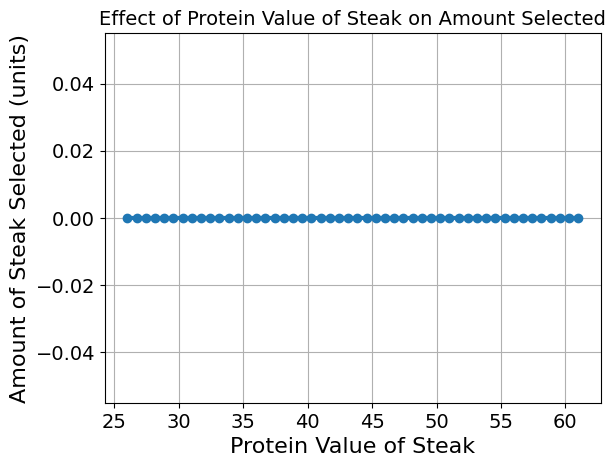

In [ ]:
# Initialize the range of protein values for steak
protein_values = np.linspace(26, 61, 50)
selected_steak_quantities = []

# Define a function to solve the model with a given protein value for steak
def solve_model(protein_value):
    model = pyo.ConcreteModel()
    food_items = ['broccoli', 'bread', 'steak', 'Popeyes', 'water']
    nutrition_data = {
        'Protein': [2.6, 3.5, protein_value, 76, 0],  # Update protein value for steak
        'Carbohydrates': [6, 19.5, 0, 36, 0],
        'Fat': [0.3, 0.84, 7.6, 64, 0],
        'Fiber': [2, 1.16, 0, 0, 0],
        'Volume': [2.6, 1.41, 3, 25, 10],
        'Price': [2, 1.5, 6, 25, 2.5]
    }

    bounds = {
        'Protein': 70,
        'Carbohydrates': 250,
        'Fat': 70,
        'Fiber': 35,
        'Volume': 90
    }

    model.food_quantities = pyo.Var(food_items, domain=pyo.NonNegativeReals)

    model.obj = pyo.Objective(expr=sum(model.food_quantities[i] * nutrition_data['Price'][j]
                                       for j, i in enumerate(food_items)), sense=pyo.minimize)

    model.protein_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Protein'][j]
                                                       for j, i in enumerate(food_items)) >= bounds['Protein'])
    model.carbohydrates_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Carbohydrates'][j]
                                                             for j, i in enumerate(food_items)) >= bounds['Carbohydrates'])
    model.fat_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fat'][j]
                                                   for j, i in enumerate(food_items)) >= bounds['Fat'])
    model.fiber_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fiber'][j]
                                                     for j, i in enumerate(food_items)) >= bounds['Fiber'])
    model.volume_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Volume'][j]
                                                      for j, i in enumerate(food_items)) <= bounds['Volume'])
    model.water_constraint = pyo.Constraint(expr=model.food_quantities['water'] == 3)

    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)

    # Return the selected quantity of steak
    return pyo.value(model.food_quantities['steak'])

# Loop over the range of protein values and solve the model for each
for protein_value in protein_values:
    selected_steak_quantities.append(solve_model(protein_value))

# Plot the results
plt.plot(protein_values, selected_steak_quantities, marker='o')
plt.title('Effect of Protein Value of Steak on Amount Selected')
plt.xlabel('Protein Value of Steak')
plt.ylabel('Amount of Steak Selected (units)')
plt.grid(True)
plt.show()

In this graph, we can see that even if the steak contains 61 grams of protein per 3oz, it would still not be selected as a part of the diet. Thus, protein might not be a determining factor.
Next, we tried to change the amount of fat contained in a piece of 3oz steak, from 5 grams to 20 grams per 3oz.

###3.2 Fat Modifications
In this section, we looped through fat values for a 3oz steak from 5 to 20, and figure out how does the amount of steak chosen changes over the loop.

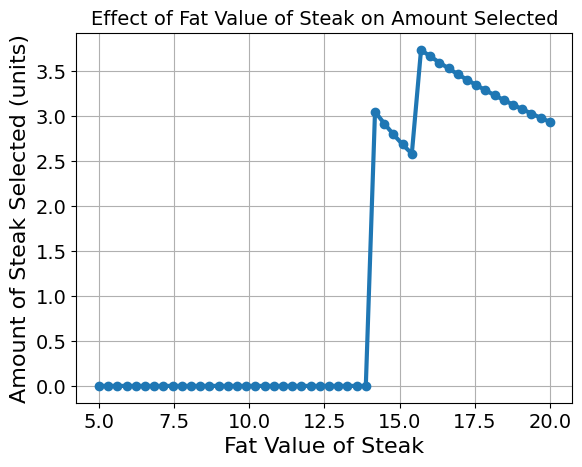

In [ ]:
# Initialize the range of fat values for steak
fat_values = np.linspace(5, 20, 50)
selected_steak_quantities = []

# Define a function to solve the model with a given fat value for steak
def solve_model(fat_value):
    model = pyo.ConcreteModel()
    food_items = ['broccoli', 'bread', 'steak', 'Popeyes', 'water']

    nutrition_data = {
        'Protein': [2.6, 3.5, 26, 76, 0],
        'Carbohydrates': [6, 19.5, 0, 36, 0],
        'Fat': [0.3, 0.84, fat_value, 64, 0],  # Update fat value for steak
        'Fiber': [2, 1.16, 0, 0, 0],
        'Volume': [2.6, 1.41, 3, 25, 10],
        'Price': [2, 1.5, 6, 25, 2.5]
    }

    bounds = {
        'Protein': 70,
        'Carbohydrates': 250,
        'Fat': 70,
        'Fiber': 35,
        'Volume': 90
    }

    model.food_quantities = pyo.Var(food_items, domain=pyo.NonNegativeReals)

    model.obj = pyo.Objective(expr=sum(model.food_quantities[i] * nutrition_data['Price'][j]
                                       for j, i in enumerate(food_items)), sense=pyo.minimize)

    model.protein_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Protein'][j]
                                                       for j, i in enumerate(food_items)) >= bounds['Protein'])
    model.carbohydrates_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Carbohydrates'][j]
                                                             for j, i in enumerate(food_items)) >= bounds['Carbohydrates'])
    model.fat_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fat'][j]
                                                   for j, i in enumerate(food_items)) >= bounds['Fat'])
    model.fiber_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fiber'][j]
                                                     for j, i in enumerate(food_items)) >= bounds['Fiber'])
    model.volume_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Volume'][j]
                                                      for j, i in enumerate(food_items)) <= bounds['Volume'])
    model.water_constraint = pyo.Constraint(expr=model.food_quantities['water'] == 3)

    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)

    # Return the selected quantity of stea
    return pyo.value(model.food_quantities['steak'])

# Loop over the range of fat values and solve the model for each
for fat_value in fat_values:
    selected_steak_quantities.append(solve_model(fat_value))

# Plot the results
plt.plot(fat_values, selected_steak_quantities, marker='o')
plt.title('Effect of Fat Value of Steak on Amount Selected')
plt.xlabel('Fat Value of Steak')
plt.ylabel('Amount of Steak Selected (units)')
plt.grid(True)
plt.show()

Now, in the above graph, we can see that the amount of steak selected dramatically increased to 3 when the fat value reaches around 13, and then started to decrease as the steak contains more fat but still not enough for the model to exclude Popeyes. As the fat value increases more to around 15.5, the amount of steak selected increased again and reached around 3.7. We speculate that this is because that the steak's relative nutritional value has exceeded that of Popeyes.

####3.2.1 Turning Point 1: Fat per 3oz steak = 14

In [ ]:
model = pyo.ConcreteModel()
food_items = ['broccoli', 'bread', 'steak', 'Popeyes', 'water']

nutrition_data = {
    'Protein': [2.6, 3.5, 26, 76, 0],
    'Carbohydrates': [6, 19.5, 0, 36, 0],
    'Fat': [0.3, 0.84, 14, 64, 0],
    'Fiber': [2, 1.16, 0, 0, 0],
    'Volume': [2.6, 1.41, 3, 25, 10],
    'Price': [2, 1.5, 6, 25, 2.5]
}

bounds = {
    'Protein': 70,
    'Carbohydrates': 250,
    'Fat': 70,
    'Fiber': 35,
    'Volume': 90
}

model.food_quantities = pyo.Var(food_items, domain=pyo.NonNegativeReals)

model.obj = pyo.Objective(expr=sum(model.food_quantities[i] * nutrition_data['Price'][j]
                                   for j, i in enumerate(food_items)), sense=pyo.minimize)

model.protein_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Protein'][j]
                                                   for j, i in enumerate(food_items)) >= bounds['Protein'])
model.carbohydrates_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Carbohydrates'][j]
                                                         for j, i in enumerate(food_items)) >= bounds['Carbohydrates'])
model.fat_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fat'][j]
                                               for j, i in enumerate(food_items)) >= bounds['Fat'])
model.fiber_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fiber'][j]
                                                 for j, i in enumerate(food_items)) >= bounds['Fiber'])
model.volume_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Volume'][j]
                                                  for j, i in enumerate(food_items)) <= bounds['Volume'])
model.popeyes_constraint = pyo.Constraint(expr=model.food_quantities['water'] >= 3)

solver = pyo.SolverFactory('ipopt')
results = solver.solve(model, tee=True)

# Print the results
print("Status:", results.solver.termination_condition)
print("Optimal solution:")
for i in food_items:
    print(f"{i}: {pyo.value(model.food_quantities[i]):.2f} units")

# Print the total price
total_price = sum(pyo.value(model.food_quantities[i]) * nutrition_data['Price'][j]
                  for j, i in enumerate(food_items))
print(f"Total price: ${total_price:.2f}")

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

As seen in the above model, the fat value per 3oz of steak is now 14 grams. In the model output, Popeyes is only selected 0.24 units, which is significantly different from the baseline model output. The amount of broccoli and bread also changed significantly, leading to a more balanced diet.

####3.2.2 Turning Point 2: Fat per 3oz steak = 15.5

In [ ]:
model = pyo.ConcreteModel()
food_items = ['broccoli', 'bread', 'steak', 'Popeyes', 'water']

nutrition_data = {
    'Protein': [2.6, 3.5, 26, 76, 0],
    'Carbohydrates': [6, 19.5, 0, 36, 0],
    'Fat': [0.3, 0.84, 15.5, 64, 0],
    'Fiber': [2, 1.16, 0, 0, 0],
    'Volume': [2.6, 1.41, 3, 25, 10],
    'Price': [2, 1.5, 6, 25, 2.5]
}

bounds = {
    'Protein': 70,
    'Carbohydrates': 250,
    'Fat': 70,
    'Fiber': 35,
    'Volume': 90
}

model.food_quantities = pyo.Var(food_items, domain=pyo.NonNegativeReals)

model.obj = pyo.Objective(expr=sum(model.food_quantities[i] * nutrition_data['Price'][j]
                                   for j, i in enumerate(food_items)), sense=pyo.minimize)

model.protein_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Protein'][j]
                                                   for j, i in enumerate(food_items)) >= bounds['Protein'])
model.carbohydrates_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Carbohydrates'][j]
                                                         for j, i in enumerate(food_items)) >= bounds['Carbohydrates'])
model.fat_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fat'][j]
                                               for j, i in enumerate(food_items)) >= bounds['Fat'])
model.fiber_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fiber'][j]
                                                 for j, i in enumerate(food_items)) >= bounds['Fiber'])
model.volume_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Volume'][j]
                                                  for j, i in enumerate(food_items)) <= bounds['Volume'])
model.popeyes_constraint = pyo.Constraint(expr=model.food_quantities['water'] >= 3)

solver = pyo.SolverFactory('ipopt')
results = solver.solve(model, tee=True)

# Print the results
print("Status:", results.solver.termination_condition)
print("Optimal solution:")
for i in food_items:
    print(f"{i}: {pyo.value(model.food_quantities[i]):.2f} units")

# Print the total price
total_price = sum(pyo.value(model.food_quantities[i]) * nutrition_data['Price'][j]
                  for j, i in enumerate(food_items))
print(f"Total price: ${total_price:.2f}")

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Now as the fat value of a 3oz steak increase to 15.5, the amount chosen has increased to 3.79 units. Popeyes is completely excluded from the final result as well, having 0 units selected.

####3.2.3 Changes in Amount of Other Types of Food

The following graph shows how each of the items selected change as we increase steak's fat nutritional value:

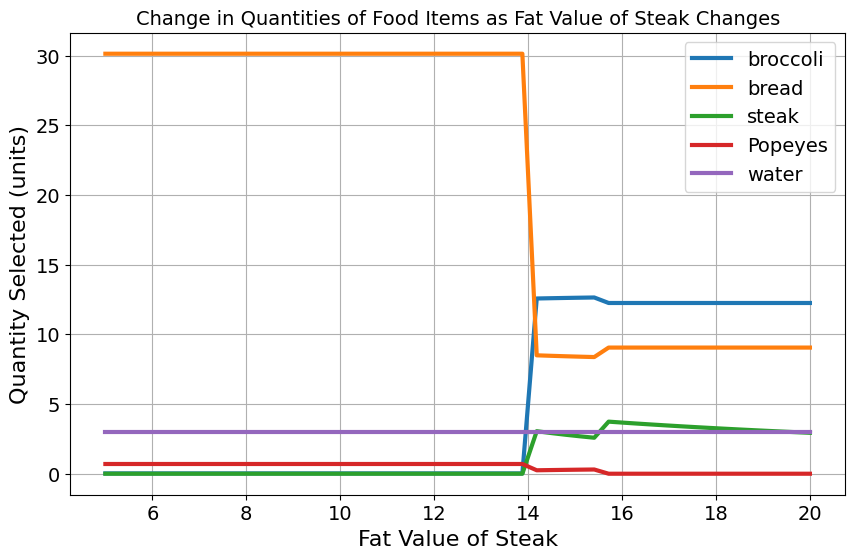

In [ ]:
# Initialize the range of fat values for steak
fat_values = np.linspace(5, 20, 50)

food_items = ['broccoli', 'bread', 'steak', 'Popeyes', 'water']
quantities = {item: [] for item in food_items}  # To store quantities of all food items

# Define a function to solve the model with a given fat value for steak
def solve_model(fat_value):
    model = pyo.ConcreteModel()
    nutrition_data = {
        'Protein': [2.6, 3.5, 26, 76, 0],
        'Carbohydrates': [6, 19.5, 0, 36, 0],
        'Fat': [0.3, 0.84, fat_value, 64, 0],  # Update fat value for steak
        'Fiber': [2, 1.16, 0, 0, 0],
        'Volume': [2.6, 1.41, 3, 25, 10],
        'Price': [2, 1.5, 6, 25, 2.5]
    }

    bounds = {
        'Protein': 70,
        'Carbohydrates': 250,
        'Fat': 70,
        'Fiber': 35,
        'Volume': 90
    }

    model.food_quantities = pyo.Var(food_items, domain=pyo.NonNegativeReals)

    model.obj = pyo.Objective(expr=sum(model.food_quantities[i] * nutrition_data['Price'][j]
                                       for j, i in enumerate(food_items)), sense=pyo.minimize)

    model.protein_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Protein'][j]
                                                       for j, i in enumerate(food_items)) >= bounds['Protein'])
    model.carbohydrates_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Carbohydrates'][j]
                                                             for j, i in enumerate(food_items)) >= bounds['Carbohydrates'])
    model.fat_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fat'][j]
                                                   for j, i in enumerate(food_items)) >= bounds['Fat'])
    model.fiber_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Fiber'][j]
                                                     for j, i in enumerate(food_items)) >= bounds['Fiber'])
    model.volume_constraint = pyo.Constraint(expr=sum(model.food_quantities[i] * nutrition_data['Volume'][j]
                                                      for j, i in enumerate(food_items)) <= bounds['Volume'])
    model.water_constraint = pyo.Constraint(expr=model.food_quantities['water'] == 3)

    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)

    # Return the selected quantity of each food item
    return {item: pyo.value(model.food_quantities[item]) for item in food_items}

# Loop over the range of fat values and solve the model for each
for fat_value in fat_values:
    food_quantities = solve_model(fat_value)

    # Store the quantity for each food item at the current fat value
    for item in food_items:
        quantities[item].append(food_quantities[item])

# Plot the results
plt.figure(figsize=(10, 6))
for item in food_items:
    plt.plot(fat_values, quantities[item], label=item)

plt.title('Change in Quantities of Food Items as Fat Value of Steak Changes')
plt.xlabel('Fat Value of Steak')
plt.ylabel('Quantity Selected (units)')
plt.legend()
plt.grid(True)
plt.show()